In [30]:
import os
import torch
import torchvision.transforms as T

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.image import imread

import numpy as np

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

import requests
from PIL import Image
from torchvision import transforms

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegressionCV

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [31]:
def get_model():
    dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
    return dinov2_vitb14


def get_image(path): # returns torch.tesnor
    # get image corresponding to path
    img = imread(path)

    if img.shape[-1] != 3:
        return
    # initialize transformations for images
    transform = T.Compose([
        T.ToTensor(),
        T.Resize((224, 224)),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

    # apply transformations to image
    img = transform(img)[:3].unsqueeze(0)

    return img


def get_dataset(cat_img_path, dog_imgs_path, number_of_images_per_class): # returns torch.tensor for images
    images = []                                                           # returns numpy.ndarray for labels
    labels = []
    image_names = [] # Added line
    cat_img_names = os.listdir(cat_img_path)
    np.random.shuffle(cat_img_names)

    for name in cat_img_names[:number_of_images_per_class]:
        img_path = os.path.join(cat_img_path, name)
        extension = img_path.split('.')[-1]
        if extension != 'db':
            tmp_img = get_image(img_path)
            if tmp_img is not None:
                images.append(tmp_img)
                labels.append(torch.tensor(0))
                image_names.append(name)  # Added line

    dog_img_names = os.listdir(dog_imgs_path)
    np.random.shuffle(dog_img_names)
    for name in dog_img_names[:number_of_images_per_class]:
        img_path = os.path.join(dog_imgs_path, name)
        extension = img_path.split('.')[-1]
        if extension != 'db':
            tmp_img = get_image(img_path)
            if tmp_img is not None:
                images.append(tmp_img)
                labels.append(torch.tensor(1))
                image_names.append(name)  # Added line

    images = torch.cat(images, dim=0)
    labels = np.array(labels)

    return images, labels, image_names


def get_image_features(model, images): # returns numpy.ndarray
    model.eval()
    features = []
    for img in tqdm(images):
        with torch.no_grad():
            x = model.prepare_tokens_with_masks(img.unsqueeze(0))
            for i, blk in enumerate(model.blocks):
                x = blk(x)
            x = model.norm(x)

            img_features = x[:, 0, :]
            features.append(img_features)
    features = torch.cat(features, dim=0)
    print()
    return features.detach().numpy()


def get_patch_features(model, images): # returns numpy.ndarray
    model.eval()
    features = []
    for img in tqdm(images):
        with torch.no_grad():
            x = model.prepare_tokens_with_masks(img)
            for i, blk in enumerate(model.blocks):
                x = blk(x)
            x = model.norm(x)

            patch_features = x[:, 1:, :]
            features.append(img_features)
    features = torch.cat(features, dim=0)
    return features.detach().numpy()

In [32]:
# Paths to the image folders
cat_img_path = 'sample_data/images/Cat'
dog_img_path = 'sample_data/images/Dog'

# Number of images per class
number_of_images_per_class = 300
images, labels, image_names = get_dataset(cat_img_path, dog_img_path, 300)
model = get_model()
img_features = get_image_features(model, images)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


  0%|          | 0/600 [00:00<?, ?it/s]

In [33]:
img_features.shape

(600, 768)

In [34]:
np.count_nonzero(labels == 1)

300

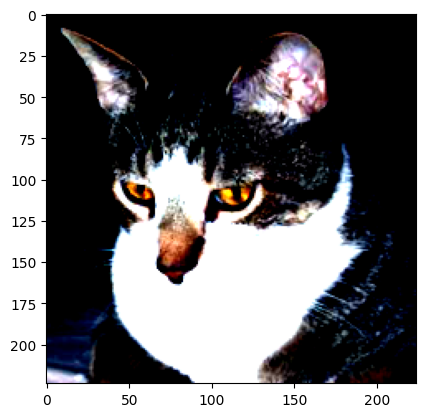

In [35]:
plt.imshow(images[113].permute(1, 2, 0))

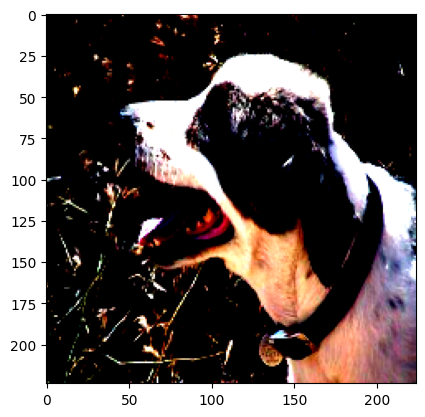

In [36]:
plt.imshow(images[312].permute(1, 2, 0))

1. Using vector representations of images (see get_image_features - function), using PCA and t-SNE dimensionality reduction algorithms to depict these vectors in 2D dimensionality, according to their classification.

In [37]:
# Performing PCA dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(img_features)

# Performing t-SNE dimensionality reduction
tsne = TSNE(n_components=2, perplexity=10)
tsne_result = tsne.fit_transform(img_features)

Text(0.5, 1.0, 'PCA')

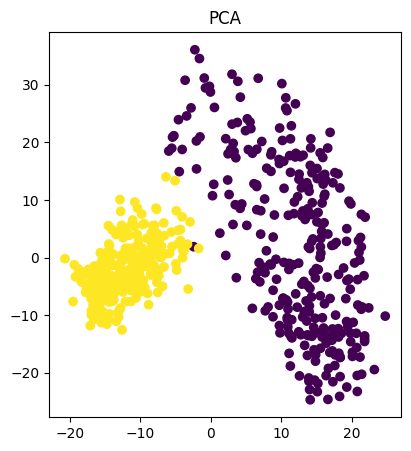

In [57]:
# Performing PCA dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(img_features[:len(images)])

# Performing t-SNE dimensionality reduction
tsne = TSNE(n_components=2, perplexity=10)
tsne_result = tsne.fit_transform(img_features[:len(images)])

# Plotting PCA results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels[:len(images)])
plt.title('PCA')

Text(0.5, 1.0, 't-SNE')

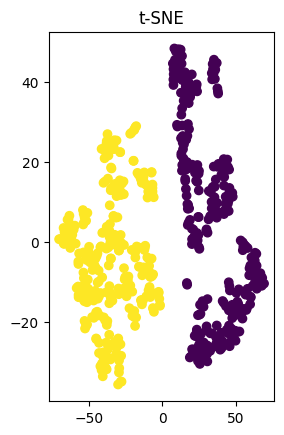

In [53]:
# Plotting t-SNE results
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels[:len(images)])
plt.title('t-SNE')

2. Using vector representations of images, solve the classification problem by means of k-NN, Logistic Regression and SVM.

In [ ]:
# Prepare the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Train the models
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

lr = LogisticRegression()
lr.fit(X_train, y_train)

svm = SVC()
svm.fit(X_train, y_train)

# Make predictions
knn_pred = knn.predict(X_test)
lr_pred = lr.predict(X_test)
svm_pred = svm.predict(X_test)

# Evaluate the models
knn_acc = accuracy_score(y_test, knn_pred)
lr_acc = accuracy_score(y_test, lr_pred)
svm_acc = accuracy_score(y_test, svm_pred)

knn_f1 = f1_score(y_test, knn_pred)
lr_f1 = f1_score(y_test, lr_pred)
svm_f1 = f1_score(y_test, svm_pred)




In [ ]:
# Print the classification results
print("k-NN Accuracy:", knn_acc)
print("k-NN F1 Score:", knn_f1)
print("Logistic Regression Accuracy:", lr_acc)
print("Logistic Regression F1 Score:", lr_f1)
print("SVM Accuracy:", svm_acc)
print("SVM F1 Score:", svm_f1)

k-NN Accuracy: 0.55
k-NN F1 Score: 0.5
Logistic Regression Accuracy: 0.6
Logistic Regression F1 Score: 0.5789473684210527
SVM Accuracy: 0.525
SVM F1 Score: 0.4864864864864865


3. Using different metrics, compare the above algorithms. (Accuracy, F1Score). For models such as LR and SVM, also calculate the AUC and draw the ROC curve.

Logistic Regression AUC: 0.4912280701754386
SVM AUC: 0.5914786967418546


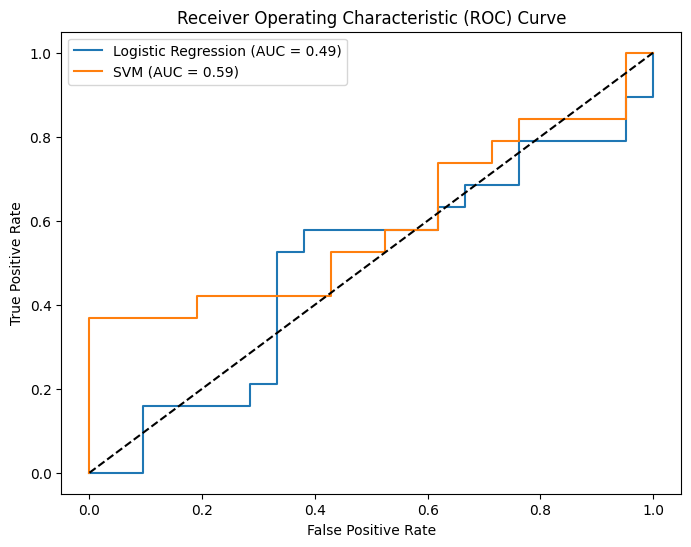

In [ ]:

# Calculate AUC and draw ROC curve for Logistic Regression
lr_probs = lr.predict_proba(X_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# Calculate AUC and draw ROC curve for SVM
svm_probs = svm.decision_function(X_test)
svm_auc = roc_auc_score(y_test, svm_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)

# Print the AUC scores
print("Logistic Regression AUC:", lr_auc)
print("SVM AUC:", svm_auc)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = {:.2f})'.format(lr_auc))
plt.plot(svm_fpr, svm_tpr, label='SVM (AUC = {:.2f})'.format(svm_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


4. Using patch features (see get_patch_features - function), reproduce the results of the DINov2 article using PCA for several images.

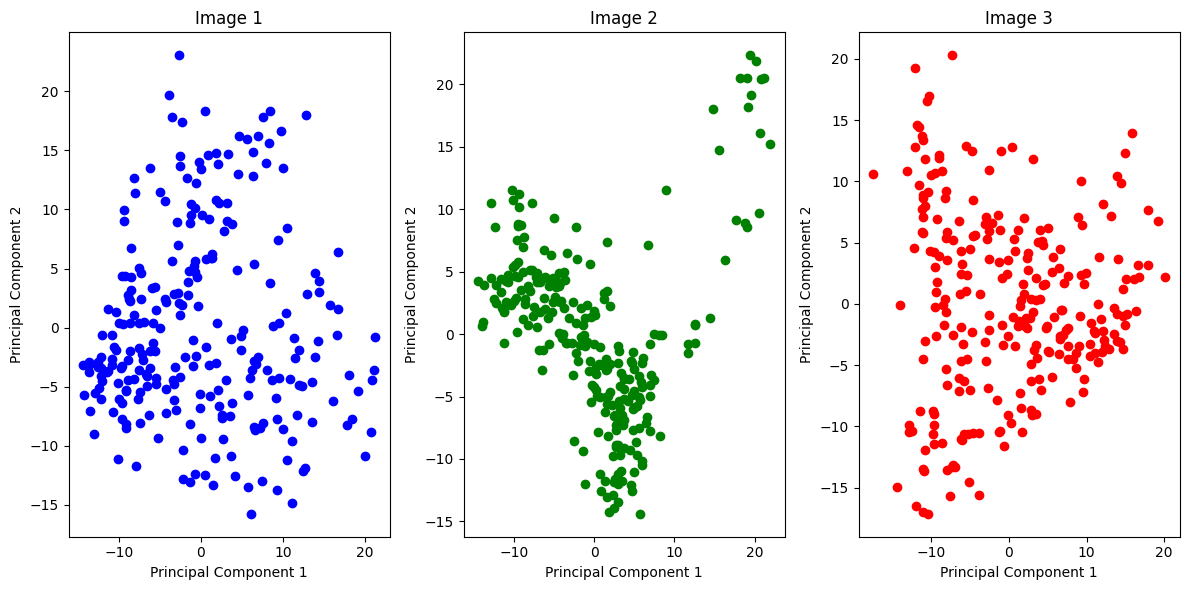

In [ ]:
image_paths = ['sample_data/images/Cat/1.jpg', 'sample_data/images/Dog/2.jpg', 'sample_data/images/Cat/3.jpg']

# Preprocess and prepare the images
images = []
for path in image_paths:
    img = Image.open(path).convert("RGB")
    img = T.Resize((224, 224))(img)
    img = T.ToTensor()(img)
    img = T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))(img)
    images.append(img)

# Get the patch features for each image
patch_features_list = []
for image in images:
    patch_features = get_patch_features(model, image.unsqueeze(0))
    patch_features_list.append(patch_features)

# Apply PCA for dimensionality reduction for each image
pca_list = []
pca_features_list = []
for patch_features in patch_features_list:
    # Reshape patch features
    patch_features_reshaped = patch_features.reshape(-1, patch_features.shape[-1])

    # Apply PCA
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(patch_features_reshaped)

    pca_list.append(pca)
    pca_features_list.append(pca_features)

# Plot the results
colors = ['blue', 'green', 'red']
plt.figure(figsize=(12, 6))
for i, pca_features in enumerate(pca_features_list):
    plt.subplot(1, 3, i+1)
    plt.scatter(pca_features[:, 0], pca_features[:, 1], color=colors[i])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'Image {i+1}')

plt.tight_layout()
plt.show()


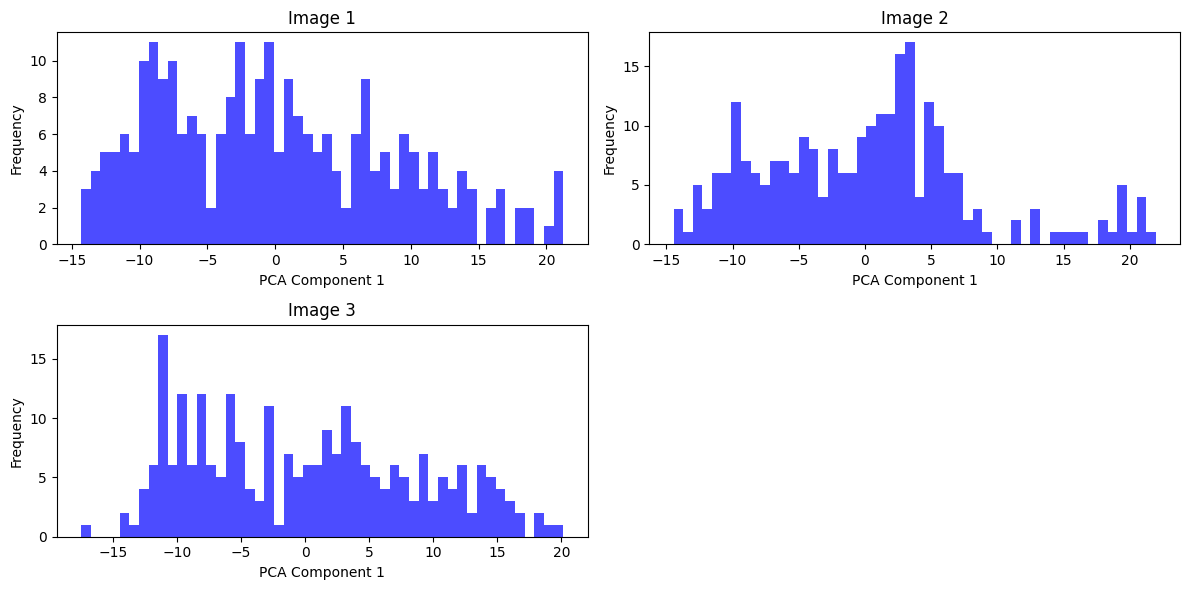

In [ ]:
image_paths = ['sample_data/images/Cat/1.jpg', 'sample_data/images/Dog/2.jpg', 'sample_data/images/Cat/3.jpg']

# Preprocess and prepare the images
images = []
for path in image_paths:
    img = Image.open(path).convert("RGB")
    img = T.Resize((224, 224))(img)
    img = T.ToTensor()(img)
    img = T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))(img)
    images.append(img)

# Get the patch features for each image
patch_features_list = []
for image in images:
    patch_features = get_patch_features(model, image.unsqueeze(0))
    patch_features_list.append(patch_features)

# Apply PCA for dimensionality reduction for each image
pca_list = []
pca_features_list = []
for patch_features in patch_features_list:
    # Reshape patch features
    patch_features_reshaped = patch_features.reshape(-1, patch_features.shape[-1])

    # Apply PCA
    pca = PCA(n_components=3)
    pca_features = pca.fit_transform(patch_features_reshaped)

    pca_list.append(pca)
    pca_features_list.append(pca_features)

# Visualize the PCA components using histograms
plt.figure(figsize=(12, 6))
for i, pca_features in enumerate(pca_features_list):
    plt.subplot(2, 2, i+1)
    plt.hist(pca_features[:, 0], bins=50, color='blue', alpha=0.7)
    plt.xlabel('PCA Component 1')
    plt.ylabel('Frequency')
    plt.title(f'Image {i+1}')

plt.tight_layout()
plt.show()
